In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import ModelVTS
import ModelTS
import TrainerTS as TP
import CompMethod as TP_Comp

In [2]:
datadir = '../Dataset/0307make07/'
mydata = TP.MyDataset(datadir + 'csi.npy',
                      datadir + 'img.npy',
                      (128, 128),
                      img='y')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.8)
valid_size = int(len(mydata) * 0.1)
test_size = int(len(mydata)) - train_size - valid_size

generator = torch.Generator()
generator.manual_seed(0)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 64, random=False, shuffle=False, generator=generator)

print(train_size, valid_size, test_size)

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
6110 763 765
6110 763 765


In [3]:
# data for Wi2Vi
transform = transforms.Compose([
    transforms.Resize([240, 320]),
    transforms.ToTensor()
 ])


mydata_wi2vi = TP.MyDataset(
    datadir + 'csi-wi2vi.npy',
                      datadir + 'img.npy',
                      (128, 128),
                     transform,
                     img='y',
                     int_image=True
                     )
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_loader_wi2vi, valid_loader_wi2vi, test_loader_wi2vi = TP.split_loader(mydata_wi2vi, train_size, valid_size, test_size, 64, random=False, shuffle=False, generator=generator)

print(train_size, valid_size, test_size)

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
6110 763 765
6110 763 765


In [4]:
args = TP.MyArgs(cuda=0, epochs=10, learning_rate=1e-4, criterion=nn.MSELoss(reduction="sum"))

In [6]:
# PROPOSED
imgencoder = ModelVTS.ImageEncoderV03b3(batchnorm=False, latent_dim=16, active_func=nn.Tanh()).to(args.device)
imgdecoder = ModelVTS.ImageDecoderV03b3(batchnorm=False, latent_dim=16, active_func=nn.Sigmoid()).to(args.device)
csiencoder = ModelVTS.CsiEncoderV03b2(batchnorm=False, latent_dim=16).to(args.device)

imgencoder.load_state_dict(torch.load('../saved/0827r2/0827r2_ImgEnV03b3FcTe100_Se400.pth'))
imgdecoder.load_state_dict(torch.load('../saved/0827r2/0827r2_ImgDeV03b3Te100_Se400.pth'))
csiencoder.load_state_dict(torch.load('../saved/0827r2/0827r2_Model_v03b2_CsiEn_LastTe100_Se400.pth'))

trainer_prop = TP.TrainerVTS(img_encoder=imgencoder, img_decoder=imgdecoder, csi_encoder=csiencoder,
                            teacher_args=args, student_args=args, 
                            train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                            temperature=1, kl_weight=1.2, latent_dim=16)

In [7]:
# COMP_AUTOENCODER
ae = TP_Comp.AutoEncoder(latent_dim=16).to(args.device)

ae.load_state_dict(torch.load('../saved/Comp_ae.pth'))

trainer_ae = TP_Comp.CompTrainer(ae,
                         args,
                         train_loader, valid_loader, test_loader)

In [8]:
# COMP_TS
imgencoder_comp = ModelTS.ImageEncoderV03b4(batchnorm=False, latent_dim=16, active_func=nn.Identity()).to(args.device)
imgdecoder_comp = ModelTS.ImageDecoderV03b4(batchnorm=False, latent_dim=16).to(args.device)
csiencoder_comp = ModelTS.CsiEncoderV03b1(batchnorm=False, latent_dim=16 , bottleneck='last_fc').to(args.device)

imgencoder_comp.load_state_dict(torch.load('../saved/0828r3/0828r3_ImgEnV03b4FcTe110_Se100.pth'))
imgdecoder_comp.load_state_dict(torch.load('../saved/0828r3/0828r3_ImgDeV03b4Te110_Se100.pth'))
csiencoder_comp.load_state_dict(torch.load('../saved/0828r3/0828r3_CsiEnV03b1Last_fcTe110_Se100.pth'))

trainer_ts = TP.TrainerTS(img_encoder=imgencoder_comp, img_decoder=imgdecoder_comp, csi_encoder=csiencoder_comp,
                            teacher_args=args, student_args=args, 
                            train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                            temperature=1, latent_dim=16)


In [9]:
# COMP_WI2VI
wi2vi = TP_Comp.Wi2Vi().to(args.device)

wi2vi.load_state_dict(torch.load('../saved/0829r1/0829r1_Wi2Vi_e200.pth'))

trainer_wi2vi = TP_Comp.CompTrainer(
                        wi2vi,
                         args,
                         train_loader_wi2vi, valid_loader_wi2vi, test_loader_wi2vi)

In [10]:
# Tests
trainer_prop.test_student(mode='test')

Student: test=612/765, loss=0.11455684155225754
Test finished. Average loss={'LOSS': 0.5105084423024475, 'STRA': 1.6379321341908055, 'DIST': 0.027326828888708764, 'IMG': 168.13128442452623}


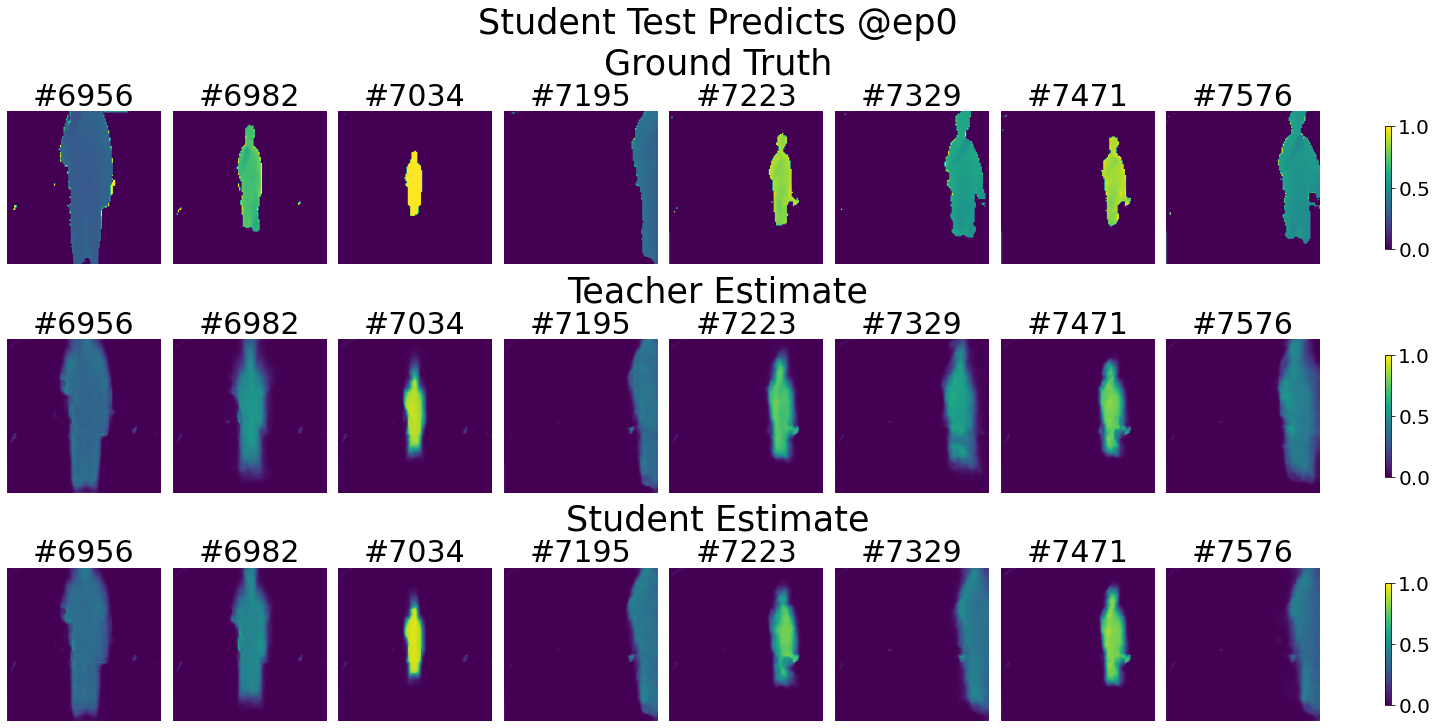

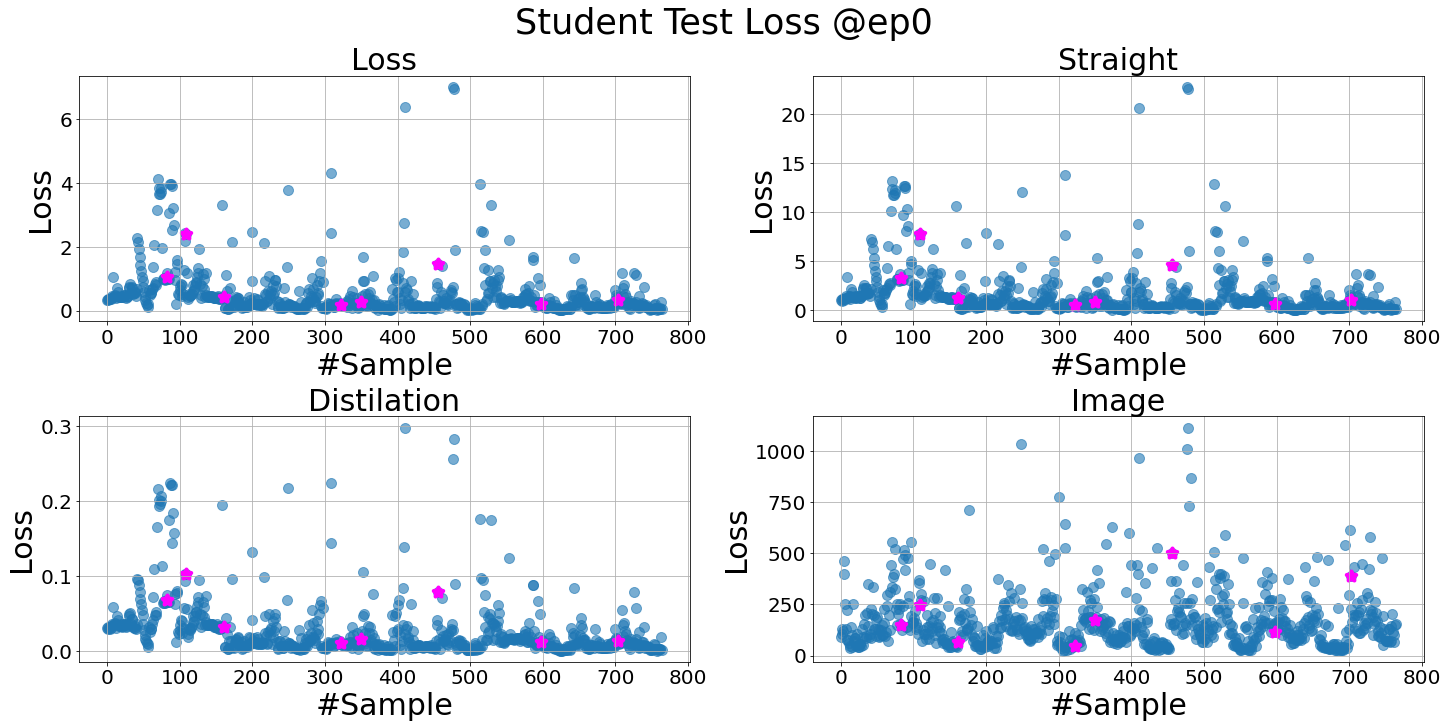

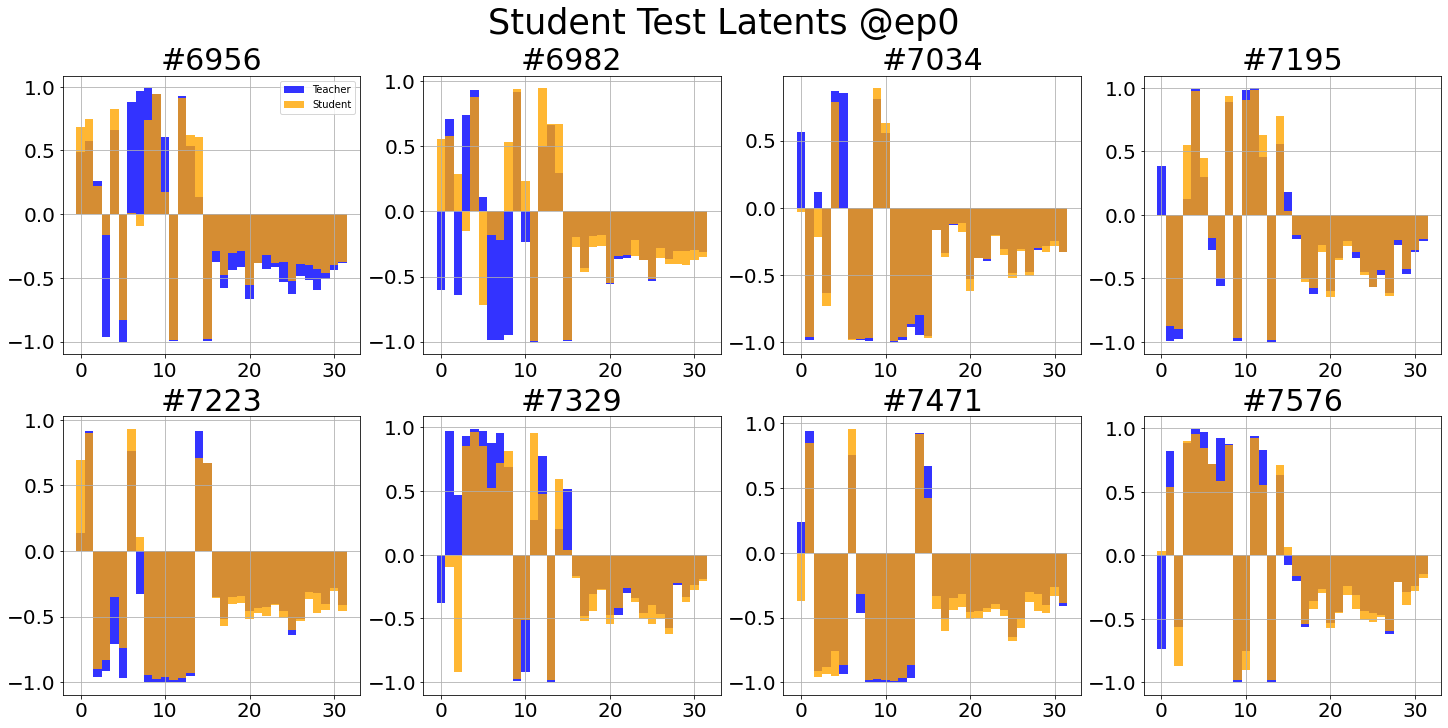

In [41]:
select_ind = np.random.choice(765, 8).tolist()
trainer_prop.plot_test(mode='s', select_ind=select_ind, select_num=8)
#select_ind = [0,95,190,285,380,475,570,665]
#trainer_prop.plot_test(mode='s', select_ind=[0,750,1500,2250,3000,3750,4500,5250], select_num=8)

In [42]:
trainer_ae.test(mode='test')

CompModel: test=612/765, loss=272.67245483398445
Test finished. Average loss={'LOSS': 256.82474815019594}


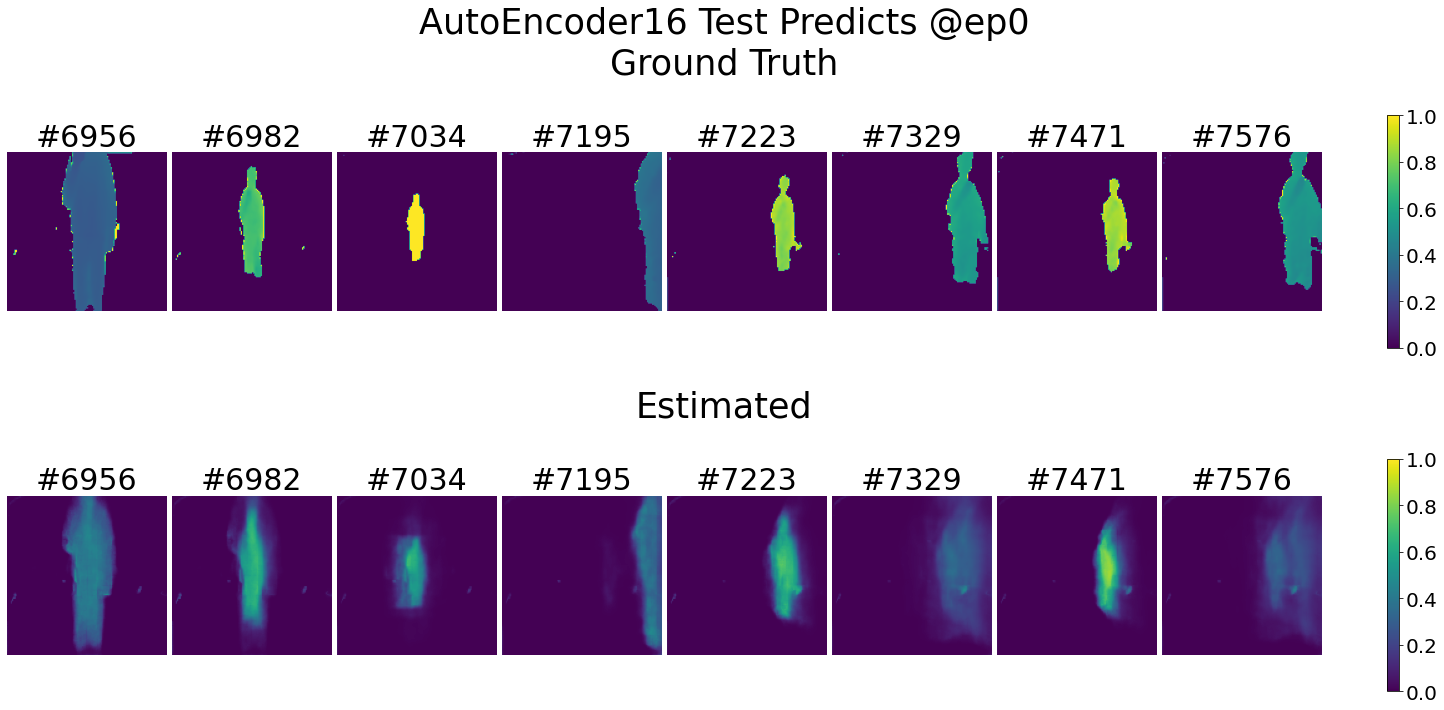

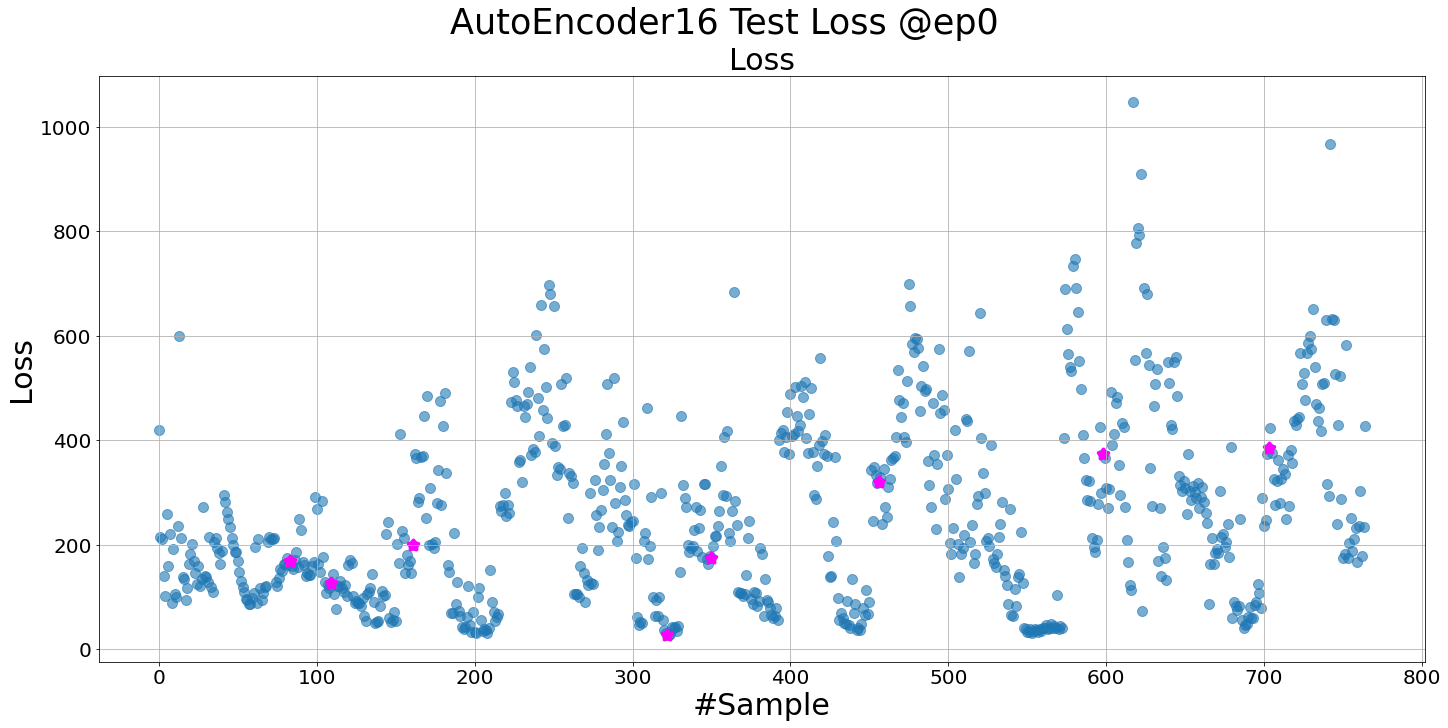

In [43]:
trainer_ae.plot_test(select_ind=select_ind, select_num=8)
#trainer_ae.plot_test(select_ind=[0,750,1500,2250,3000,3750,4500,5250], select_num=8)

In [44]:
trainer_ts.test_student(mode='test')

Student: test=612/765, loss=2787.0961914062555
Test finished. Average loss={'LOSS': 2877.9742747587316, 'STRA': 9576.192709929024, 'DIST': 7.309090687792286, 'IMG': 830.3455964929917}


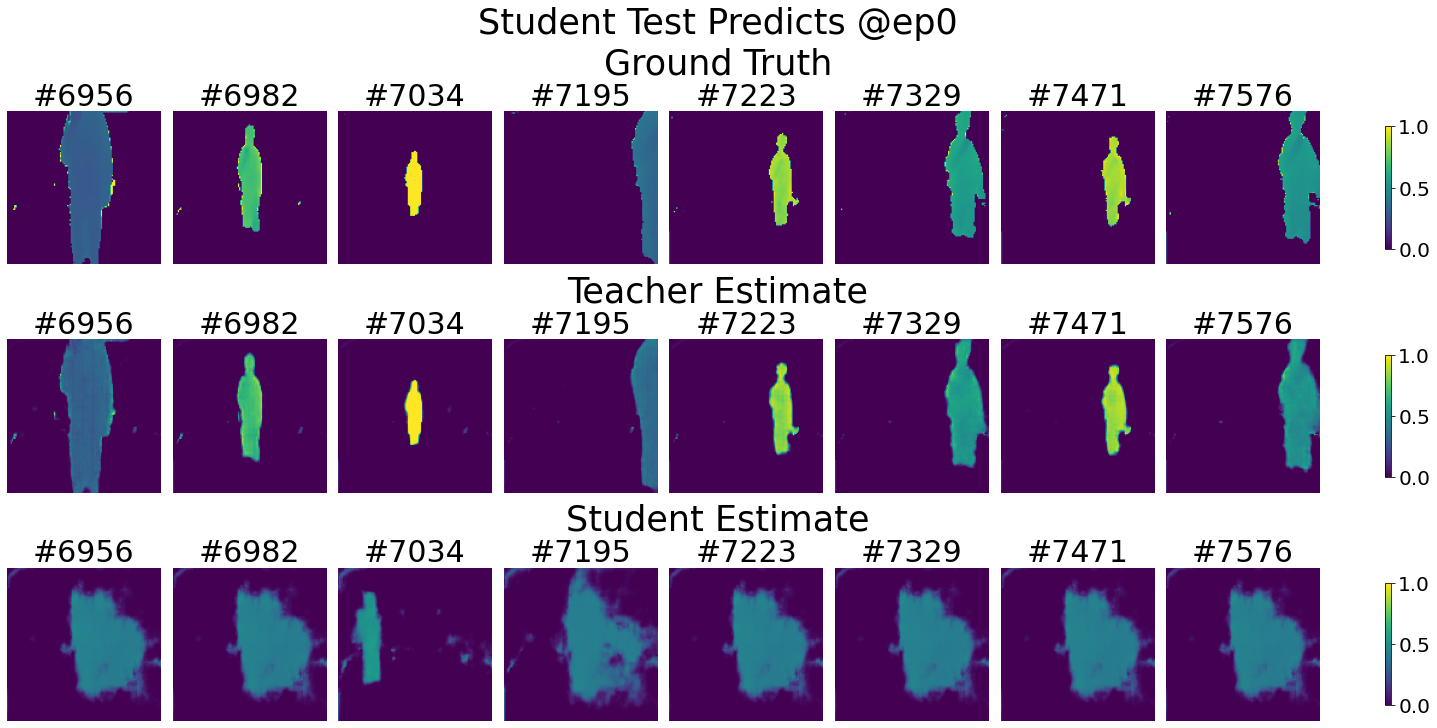

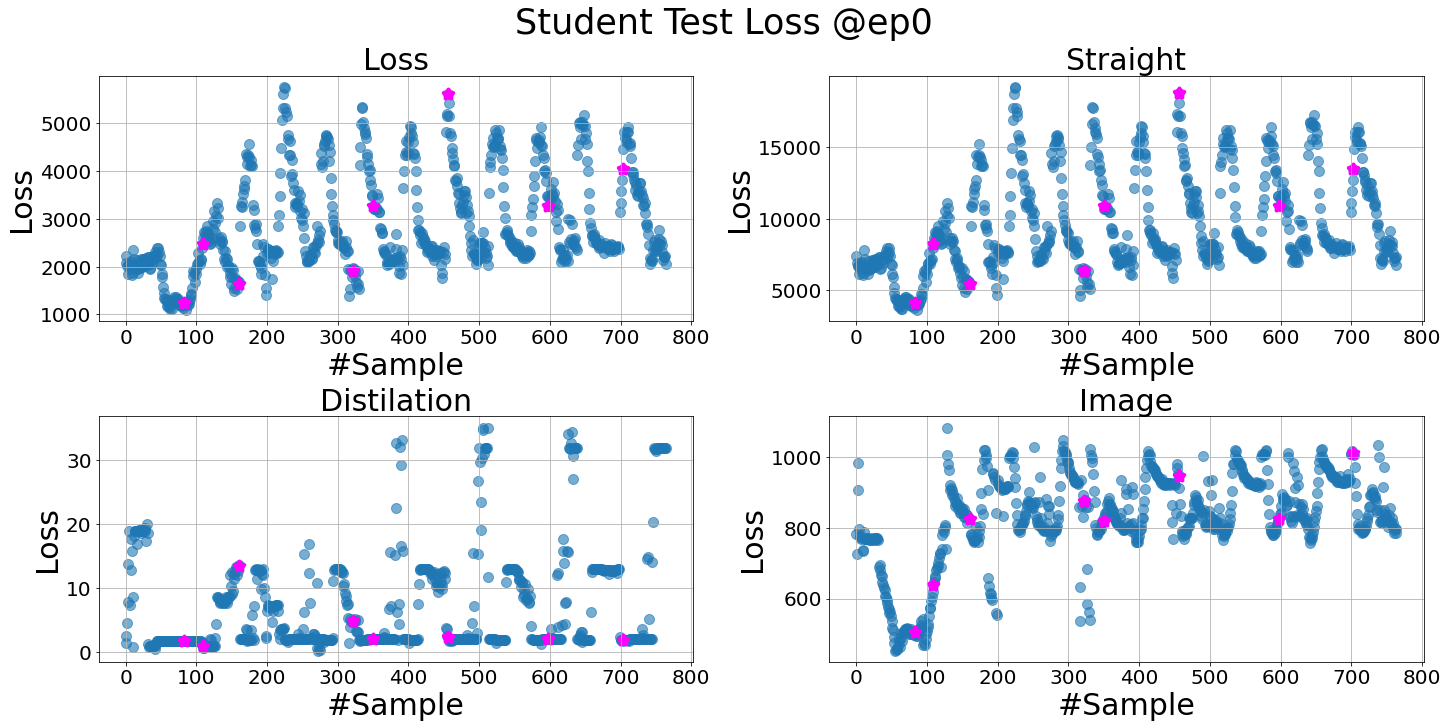

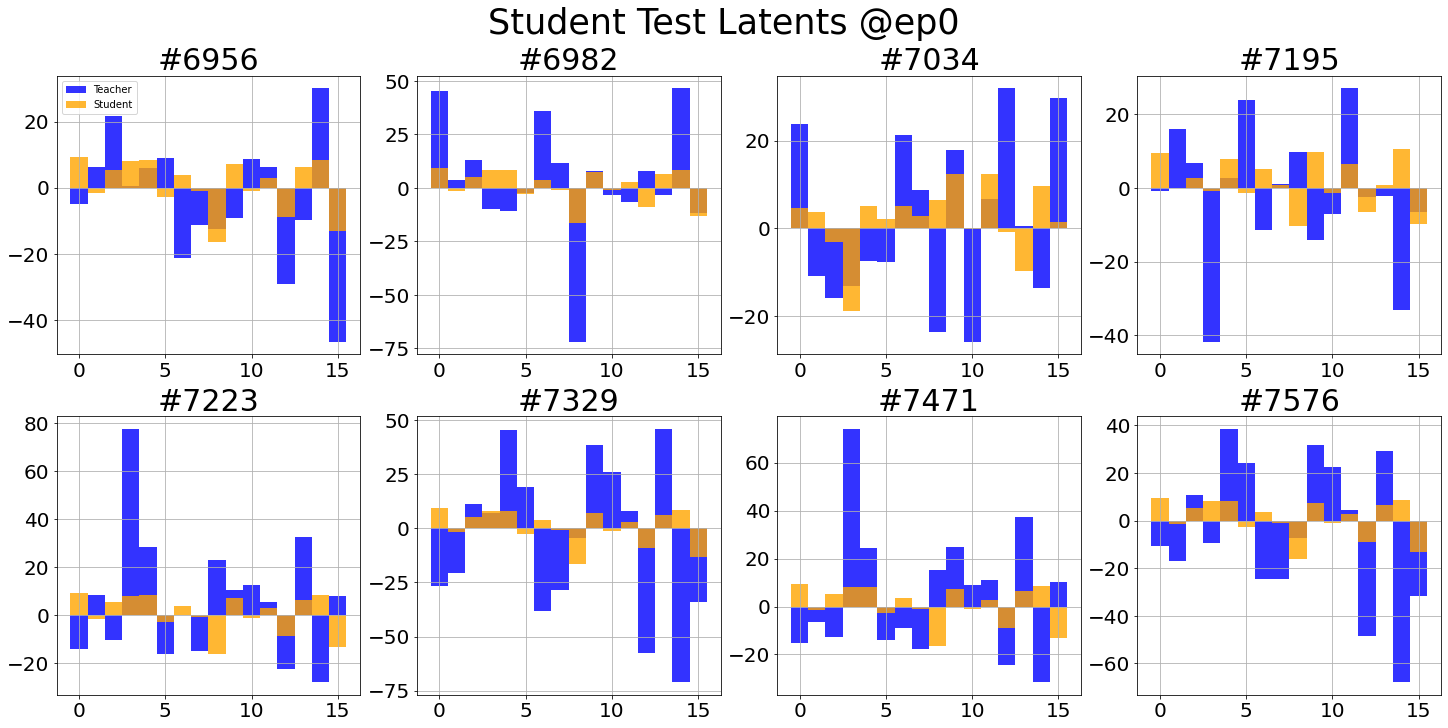

In [46]:
trainer_ts.plot_test(mode='s', select_ind=select_ind, select_num=8)
#trainer_ts.plot_test(mode='s', select_ind=[0,750,1500,2250,3000,3750,4500,5250], select_num=8)

In [47]:
trainer_wi2vi.test(mode='test')

/home/bob/datastore/Models/CompMethod.py:431: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/Copy.cpp:244.)
  data_x = data_x.to(torch.float32).to(self.args.device)


CompModel: test=612/765, loss=10020.9169921875
Test finished. Average loss={'LOSS': 9262.375189568014}


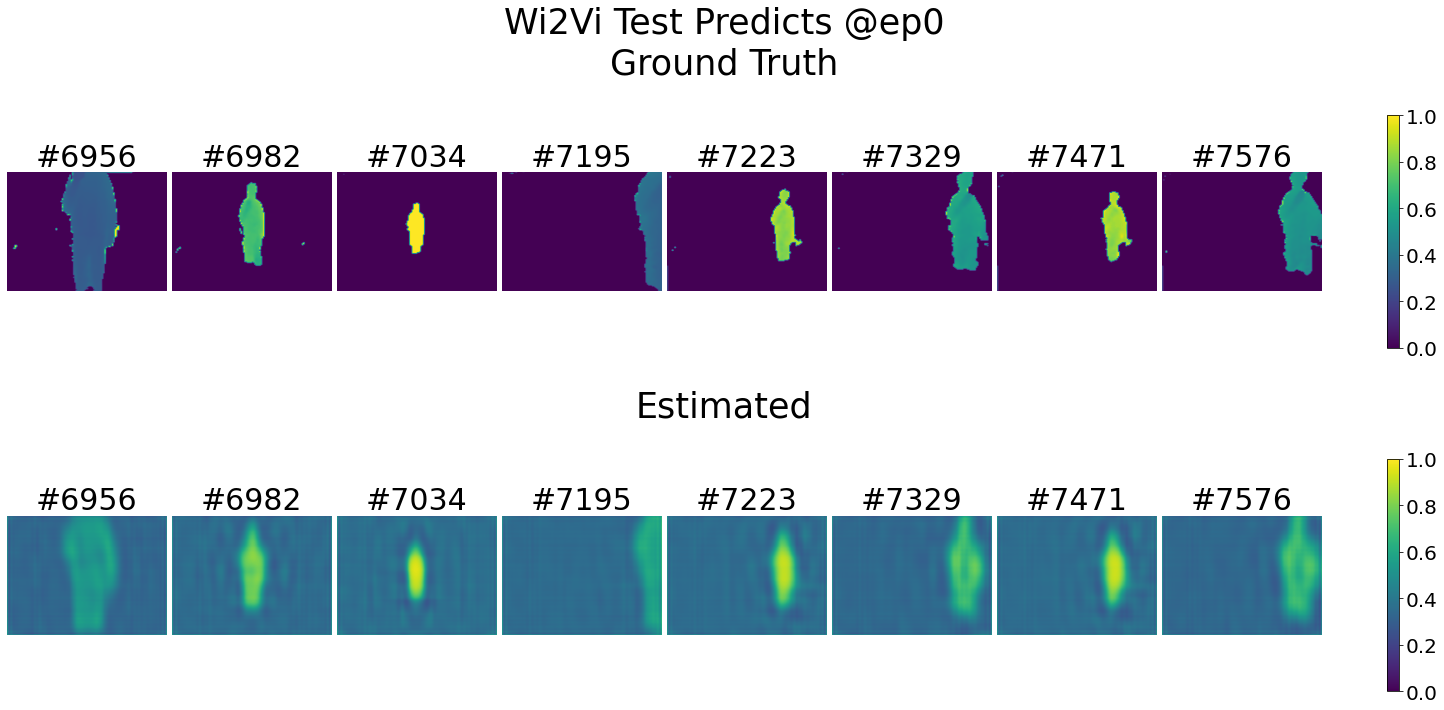

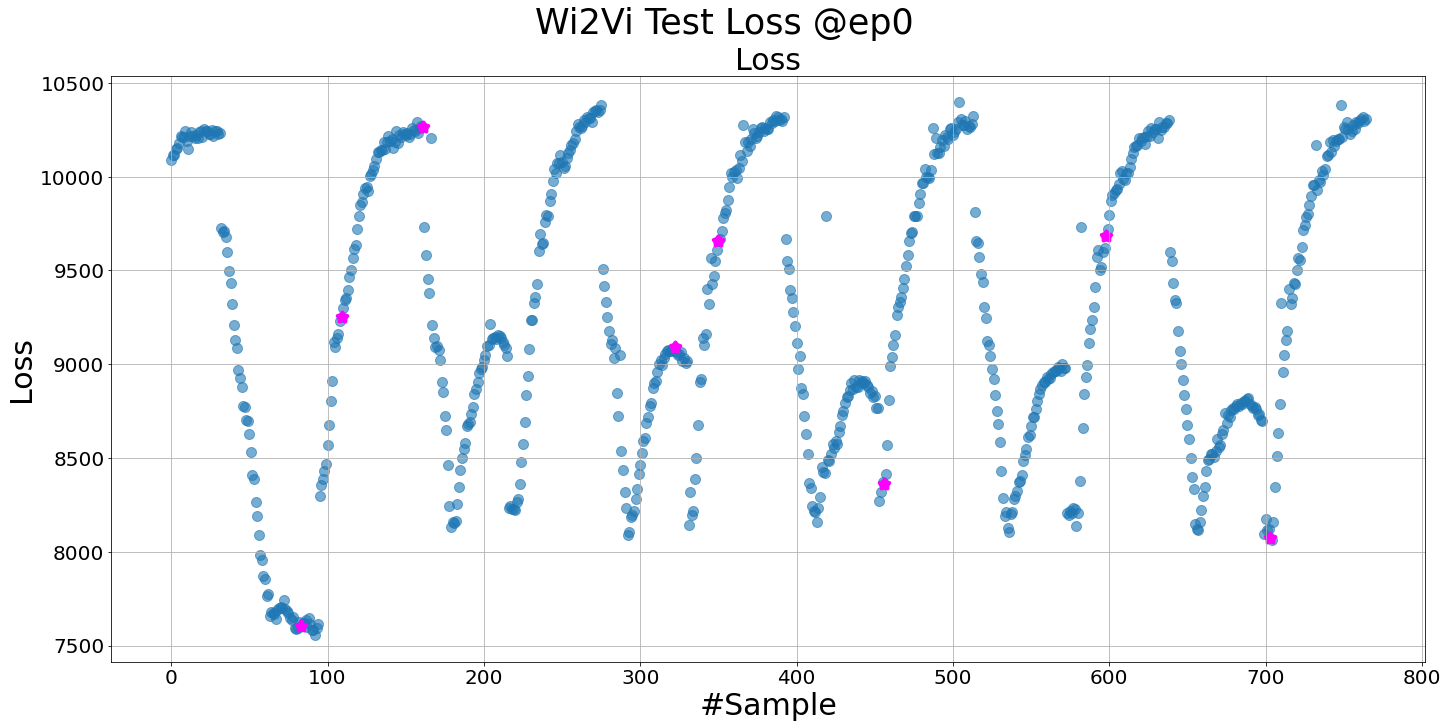

In [48]:
trainer_wi2vi.plot_test(select_ind=select_ind, select_num=8)
#trainer_wi2vi.plot_test(select_ind=[0,750,1500,2250,3000,3750,4500,5250], select_num=8)

In [8]:
np.save('../saved/0829prop.npy', trainer_prop.test_loss['s']['IMG'])

In [23]:
np.save('../saved/0829ae.npy', trainer_ae.test_loss['LOSS'])

In [24]:
np.save('../saved/0829ts.npy', trainer_ts.test_loss['s']['IMG'])

In [25]:
np.save('../saved/0829wi2vi.npy', trainer_wi2vi.test_loss['LOSS'])